<a href="https://colab.research.google.com/github/ps-research/Real-Time-Incremental-Federated-Learning-for-Weather-Prediction-with-UAV-based-Data-Collection/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install --upgrade scipy --quiet
# !pip install --upgrade tensorflow-federated --quiet

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
def load_state_data(state_dir, state_id):
    dataframes = {}
    for file in os.listdir(state_dir):
        if file.endswith('.csv'):
            file_path = os.path.join(state_dir, file)
            df = pd.read_csv(file_path)
            # Extract weather type and city id from the file name
            file_name = os.path.splitext(file)[0]  # Remove .csv extension
            weather_type, city_id = file_name.split('_city_')
            key = f"{state_id}_{weather_type}_{city_id}"
            dataframes[key] = df
    return dataframes

In [ ]:
# Load all states data into a single dictionary
def load_all_states_data(base_dir):
    all_data = {}
    for state_dir in sorted(os.listdir(base_dir)):
        full_state_path = os.path.join(base_dir, state_dir)
        if os.path.isdir(full_state_path):
            state_id = state_dir.split('_')[1]
            state_data = load_state_data(full_state_path, state_id)
            all_data.update(state_data)
    return all_data

In [ ]:
# Replace 'path_to_your_data' with the actual path to your data directory
data_dir = '/content/drive/MyDrive/ICVES 2 Data and Plots/States Weather Data/10_States'
all_data = load_all_states_data(data_dir)

In [ ]:
# Display the keys and the first few rows of each dataframe as an example
for key, df in all_data.items():
    print(f"\nKey: {key}")
    print(df.head())
    # break  # Remove this to display all dataframes


Key: 1_Stormy_1
   Temperature   Humidity  Wind Speed    Pressure  Ozone Level  UV Index  \
0    33.904776  93.766332   21.353792  954.659966   274.840763  0.611717   
1    27.208080  93.843580   27.737527  984.463028   298.853361  0.497995   
2    33.301198  99.983869   21.774091  982.137177   253.167729  1.153271   
3    22.189130  93.907693   22.899739  962.111446   278.316455  1.780891   
4    29.778175  82.202009   23.450582  961.652391   220.580166  1.565919   

        PM2.5  Solar Radiation  Precipitation  Visibility  Cloud Cover  \
0  475.370564         5.811814      70.662118    1.623903    81.789800   
1  491.967148       269.631316     171.767088    0.930578    91.162188   
2  264.379510       282.195286      86.424556    0.939382    85.155437   
3  293.470091       101.390070     186.251318    1.520409    86.489694   
4  308.243405       143.126667      81.657186    1.494024    84.410042   

   Air Density Weather Condition  
0     1.071482            Stormy  
1     1.093

In [ ]:
# Function to split data incrementally using train_test_split from scikit-learn
def get_incremental_data(dataframes, step, total_steps, train_ratio, test_ratio):
    incremental_data = {}
    for key, df in dataframes.items():
        num_samples = len(df)
        p = num_samples * P // 100
        start_idx = step * p
        end_idx = start_idx + p
        if end_idx > num_samples:
            end_idx = num_samples
        increment = df.iloc[start_idx:end_idx]

        train_data, test_data = train_test_split(increment, train_size=train_ratio, test_size=test_ratio, random_state=42)

        incremental_data[key] = (train_data, test_data)
    return incremental_data

In [ ]:
# Hyperparameters
S = 10
T = 10  # Total number of time steps (example value)
P = 100 // T
F = 3  # Frequency of Federated Learning (example value)
train_ratio = 0.8
test_ratio = 0.2

In [ ]:
# Pretty print table setup
table = PrettyTable()
table.field_names = ["Time Step", "State ID", "Weather & City ID", "Training Data Length", "Testing Data Length"]

# Example of getting incremental data for each time step
for step in range(T):
    incremental_data = get_incremental_data(all_data, step, T, train_ratio, test_ratio)
    time_step_span = sum(len(data[0]) + len(data[1]) for data in incremental_data.values())
    for key, (train_data, test_data) in incremental_data.items():
        state_id, weather_type, city_id = key.split('_')
        table.add_row([step + 1, state_id, f"{weather_type}_{city_id}", len(train_data), len(test_data)])

print(table)

+-----------+----------+-------------------+----------------------+---------------------+
| Time Step | State ID | Weather & City ID | Training Data Length | Testing Data Length |
+-----------+----------+-------------------+----------------------+---------------------+
|     1     |    1     |      Stormy_1     |          80          |          20         |
|     1     |    1     |    Overcast_13    |          79          |          20         |
|     1     |    1     |    Clear Sky_15   |          80          |          20         |
|     1     |    1     |  Partly Cloudy_12 |          79          |          20         |
|     1     |    1     |     Stormy_10     |          80          |          20         |
|     1     |    1     |  Partly Cloudy_14 |          79          |          20         |
|     1     |    1     |      Rainy_18     |          80          |          20         |
|     1     |    1     |  Partly Cloudy_17 |          79          |          20         |
|     1   

In [ ]:
# Function to create training and testing data vectors
def create_data_vectors(data_dir, T, train_ratio, test_ratio):
    all_data = load_all_states_data(data_dir)
    training_data_vector = [[] for _ in range(T)]
    testing_data_vector = [[] for _ in range(T)]

    for step in range(T):
        incremental_data = get_incremental_data(all_data, step, T, train_ratio, test_ratio)
        for state_id in sorted(set(key.split('_')[0] for key in incremental_data.keys())):
            state_train_data = []
            state_test_data = []
            for key, (train_data, test_data) in incremental_data.items():
                if key.split('_')[0] == state_id:
                    state_train_data.append((key, train_data))
                    state_test_data.append((key, test_data))
            training_data_vector[step].append(state_train_data)
            testing_data_vector[step].append(state_test_data)

    return training_data_vector, testing_data_vector

In [ ]:
# Usage
data_dir = '/content/drive/MyDrive/ICVES 2 Data and Plots/States Weather Data/10_States'
training_data_vector, testing_data_vector = create_data_vectors(data_dir, T, train_ratio, test_ratio)

In [ ]:
# Pretty print table setup
table = PrettyTable()
table.field_names = ["Time Step", "State ID", " Weather & City ID", "Training Data Length", "Testing Data Length"]

# Example of accessing training and testing data
for step in range(T):
    for state_index, (train_dfs, test_dfs) in enumerate(zip(training_data_vector[step], testing_data_vector[step])):
        for (train_key, train_df), (test_key, test_df) in zip(train_dfs, test_dfs):
            weather_city_id = train_key.split('_', 1)[1]
            table.add_row([step + 1, state_index + 1, weather_city_id, len(train_df), len(test_df)])

print(table)

+-----------+----------+--------------------+----------------------+---------------------+
| Time Step | State ID |  Weather & City ID | Training Data Length | Testing Data Length |
+-----------+----------+--------------------+----------------------+---------------------+
|     1     |    1     |      Stormy_1      |          80          |          20         |
|     1     |    1     |    Overcast_13     |          79          |          20         |
|     1     |    1     |    Clear Sky_15    |          80          |          20         |
|     1     |    1     |  Partly Cloudy_12  |          79          |          20         |
|     1     |    1     |     Stormy_10      |          80          |          20         |
|     1     |    1     |  Partly Cloudy_14  |          79          |          20         |
|     1     |    1     |      Rainy_18      |          80          |          20         |
|     1     |    1     |  Partly Cloudy_17  |          79          |          20         |

In [ ]:
# Function to generate dictionaries of dataframes
def generate_dataframes_dict(training_data_vector, testing_data_vector):
    dataframes_dict = {}

    for step in range(T):
        for state_index, (train_dfs, test_dfs) in enumerate(zip(training_data_vector[step], testing_data_vector[step])):
            train_df_combined = pd.concat([df for _, df in train_dfs], ignore_index=True)
            test_df_combined = pd.concat([df for _, df in test_dfs], ignore_index=True)

            train_key = f"train_{step + 1}_{state_index + 1}"
            test_key = f"test_{step + 1}_{state_index + 1}"

            dataframes_dict[train_key] = train_df_combined
            dataframes_dict[test_key] = test_df_combined

    return dataframes_dict


In [ ]:
# Generate the dictionary of dataframes
dataframes_dict = generate_dataframes_dict(training_data_vector, testing_data_vector)

# Example of accessing the generated dataframes
for key in sorted(dataframes_dict.keys()):
    print(f"{key}: {dataframes_dict[key].shape}")

test_10_1: (200, 13)
test_10_10: (200, 13)
test_10_2: (200, 13)
test_10_3: (200, 13)
test_10_4: (200, 13)
test_10_5: (200, 13)
test_10_6: (200, 13)
test_10_7: (200, 13)
test_10_8: (200, 13)
test_10_9: (200, 13)
test_1_1: (200, 13)
test_1_10: (200, 13)
test_1_2: (200, 13)
test_1_3: (200, 13)
test_1_4: (200, 13)
test_1_5: (200, 13)
test_1_6: (200, 13)
test_1_7: (200, 13)
test_1_8: (200, 13)
test_1_9: (200, 13)
test_2_1: (200, 13)
test_2_10: (200, 13)
test_2_2: (200, 13)
test_2_3: (200, 13)
test_2_4: (200, 13)
test_2_5: (200, 13)
test_2_6: (200, 13)
test_2_7: (200, 13)
test_2_8: (200, 13)
test_2_9: (200, 13)
test_3_1: (200, 13)
test_3_10: (200, 13)
test_3_2: (200, 13)
test_3_3: (200, 13)
test_3_4: (200, 13)
test_3_5: (200, 13)
test_3_6: (200, 13)
test_3_7: (200, 13)
test_3_8: (200, 13)
test_3_9: (200, 13)
test_4_1: (200, 13)
test_4_10: (200, 13)
test_4_2: (200, 13)
test_4_3: (200, 13)
test_4_4: (200, 13)
test_4_5: (200, 13)
test_4_6: (200, 13)
test_4_7: (200, 13)
test_4_8: (200, 13)
test_

In [ ]:
dataframes_dict['train_1_1']

,Temperature,Humidity,Wind Speed,Pressure,Ozone Level,UV Index,PM2.5,Solar Radiation,Precipitation,Visibility,Cloud Cover,Air Density,Weather Condition
0,32.794236,88.043250,29.185896,953.362965,206.856264,1.077971,262.827807,86.129988,69.898416,1.153346,89.866228,1.007436,Stormy
1,28.111997,89.846992,23.875222,974.260729,213.790096,1.023593,433.657083,84.766197,55.011061,1.250650,98.421466,1.080845,Stormy
2,20.054679,89.921567,28.058264,952.727000,279.419855,1.949516,457.095875,217.734013,180.127105,1.607913,92.739528,1.020956,Stormy
3,21.782583,82.010807,27.955655,973.046585,275.637154,1.584156,236.399045,293.814043,54.548117,1.035748,90.449010,1.054823,Stormy
4,27.978530,91.232844,29.515078,980.028589,233.057651,0.379623,401.835186,213.711239,61.907778,0.616183,99.560462,1.028788,Stormy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,25.455100,56.720613,1.569769,1000.813621,92.024351,6.004606,88.716780,849.308810,0.502124,12.503227,15.238056,1.180695,Partly Cloudy
790,35.550990,54.518615,3.435585,1001.279128,31.543091,7.500091,60.962004,734.770698,8.434635,13.091628,15.782687,1.171108,Partly Cloudy
791,31.614999,61.587525,10.804155,1001.413839,41.105803,6.275975,78.280756,868.616126,16.793334,14.178201,22.211210,1.146073,Partly Cloudy
792,34.826452,52.669891,8.514380,1014.667260,51.304804,7.945003,23.991852,781.275707,18.728401,11.467263,15.820563,1.117329,Partly Cloudy


In [ ]:
import pandas as pd

def one_hot_encode_weather(dataframes_dict):
    LABELS = ['Clear Sky', 'Partly Cloudy', 'Overcast', 'Rainy', 'Stormy']

    encoded_dataframes = {}

    for key, df in dataframes_dict.items():
        # Create a copy of the original dataframe
        encoded_df = df.copy()

        # One-hot encode the 'Weather Condition' column
        one_hot = pd.get_dummies(encoded_df['Weather Condition'], prefix='Weather', prefix_sep='_')

        # Add missing columns with 0 values
        for label in LABELS:
            if f'Weather_{label}' not in one_hot.columns:
                one_hot[f'Weather_{label}'] = 0

        # Keep only the specified labels
        one_hot = one_hot[[f'Weather_{label}' for label in LABELS]]

        # Join the one-hot encoded columns to the original dataframe
        encoded_df = pd.concat([encoded_df, one_hot], axis=1)

        # Drop the original 'Weather Condition' column
        encoded_df = encoded_df.drop('Weather Condition', axis=1)

        # Store the encoded dataframe in the new dictionary
        encoded_dataframes[key] = encoded_df

    return encoded_dataframes

In [ ]:
encoded_dataframes = one_hot_encode_weather(dataframes_dict)

In [ ]:
# Example of accessing the generated dataframes
for key in sorted(encoded_dataframes.keys()):
    print(f"{key}: {encoded_dataframes[key].shape}")

test_10_1: (200, 17)
test_10_10: (200, 17)
test_10_2: (200, 17)
test_10_3: (200, 17)
test_10_4: (200, 17)
test_10_5: (200, 17)
test_10_6: (200, 17)
test_10_7: (200, 17)
test_10_8: (200, 17)
test_10_9: (200, 17)
test_1_1: (200, 17)
test_1_10: (200, 17)
test_1_2: (200, 17)
test_1_3: (200, 17)
test_1_4: (200, 17)
test_1_5: (200, 17)
test_1_6: (200, 17)
test_1_7: (200, 17)
test_1_8: (200, 17)
test_1_9: (200, 17)
test_2_1: (200, 17)
test_2_10: (200, 17)
test_2_2: (200, 17)
test_2_3: (200, 17)
test_2_4: (200, 17)
test_2_5: (200, 17)
test_2_6: (200, 17)
test_2_7: (200, 17)
test_2_8: (200, 17)
test_2_9: (200, 17)
test_3_1: (200, 17)
test_3_10: (200, 17)
test_3_2: (200, 17)
test_3_3: (200, 17)
test_3_4: (200, 17)
test_3_5: (200, 17)
test_3_6: (200, 17)
test_3_7: (200, 17)
test_3_8: (200, 17)
test_3_9: (200, 17)
test_4_1: (200, 17)
test_4_10: (200, 17)
test_4_2: (200, 17)
test_4_3: (200, 17)
test_4_4: (200, 17)
test_4_5: (200, 17)
test_4_6: (200, 17)
test_4_7: (200, 17)
test_4_8: (200, 17)
test_

In [ ]:
encoded_dataframes['train_1_1']

,Temperature,Humidity,Wind Speed,Pressure,Ozone Level,UV Index,PM2.5,Solar Radiation,Precipitation,Visibility,Cloud Cover,Air Density,Weather_Clear Sky,Weather_Partly Cloudy,Weather_Overcast,Weather_Rainy,Weather_Stormy
0,32.794236,88.043250,29.185896,953.362965,206.856264,1.077971,262.827807,86.129988,69.898416,1.153346,89.866228,1.007436,False,False,False,False,True
1,28.111997,89.846992,23.875222,974.260729,213.790096,1.023593,433.657083,84.766197,55.011061,1.250650,98.421466,1.080845,False,False,False,False,True
2,20.054679,89.921567,28.058264,952.727000,279.419855,1.949516,457.095875,217.734013,180.127105,1.607913,92.739528,1.020956,False,False,False,False,True
3,21.782583,82.010807,27.955655,973.046585,275.637154,1.584156,236.399045,293.814043,54.548117,1.035748,90.449010,1.054823,False,False,False,False,True
4,27.978530,91.232844,29.515078,980.028589,233.057651,0.379623,401.835186,213.711239,61.907778,0.616183,99.560462,1.028788,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,25.455100,56.720613,1.569769,1000.813621,92.024351,6.004606,88.716780,849.308810,0.502124,12.503227,15.238056,1.180695,False,True,False,False,False
790,35.550990,54.518615,3.435585,1001.279128,31.543091,7.500091,60.962004,734.770698,8.434635,13.091628,15.782687,1.171108,False,True,False,False,False
791,31.614999,61.587525,10.804155,1001.413839,41.105803,6.275975,78.280756,868.616126,16.793334,14.178201,22.211210,1.146073,False,True,False,False,False
792,34.826452,52.669891,8.514380,1014.667260,51.304804,7.945003,23.991852,781.275707,18.728401,11.467263,15.820563,1.117329,False,True,False,False,False


In [ ]:
# Function to generate scikit-learn datasets from the dataframes dictionary
def generate_sklearn_datasets_from_dataframes(dataframes_dict):
    sklearn_datasets_dict = {}

    for key, df in dataframes_dict.items():
        df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
        X = df_shuffled.iloc[:, :-5]
        y = df_shuffled.iloc[:, -5:]


        sklearn_datasets_dict[key] = (X, y)

    return sklearn_datasets_dict

In [ ]:
# Generate the dictionary of scikit-learn datasets from the dataframes dictionary
sklearn_datasets_dict = generate_sklearn_datasets_from_dataframes(encoded_dataframes)

In [ ]:
# Example of accessing the generated scikit-learn datasets
for key in sorted(sklearn_datasets_dict.keys()):
    X, y = sklearn_datasets_dict[key]
    print(f"{key}: X shape {X.shape}, y shape {y.shape}")

test_10_1: X shape (200, 12), y shape (200, 5)
test_10_10: X shape (200, 12), y shape (200, 5)
test_10_2: X shape (200, 12), y shape (200, 5)
test_10_3: X shape (200, 12), y shape (200, 5)
test_10_4: X shape (200, 12), y shape (200, 5)
test_10_5: X shape (200, 12), y shape (200, 5)
test_10_6: X shape (200, 12), y shape (200, 5)
test_10_7: X shape (200, 12), y shape (200, 5)
test_10_8: X shape (200, 12), y shape (200, 5)
test_10_9: X shape (200, 12), y shape (200, 5)
test_1_1: X shape (200, 12), y shape (200, 5)
test_1_10: X shape (200, 12), y shape (200, 5)
test_1_2: X shape (200, 12), y shape (200, 5)
test_1_3: X shape (200, 12), y shape (200, 5)
test_1_4: X shape (200, 12), y shape (200, 5)
test_1_5: X shape (200, 12), y shape (200, 5)
test_1_6: X shape (200, 12), y shape (200, 5)
test_1_7: X shape (200, 12), y shape (200, 5)
test_1_8: X shape (200, 12), y shape (200, 5)
test_1_9: X shape (200, 12), y shape (200, 5)
test_2_1: X shape (200, 12), y shape (200, 5)
test_2_10: X shape (20

In [ ]:
sklearn_datasets_dict['test_1_1']

(     Temperature   Humidity  Wind Speed     Pressure  Ozone Level  UV Index  \
 0      22.818924  82.335656   24.415430   984.346564   289.047738  0.674277   
 1      29.778175  82.202009   23.450582   961.652391   220.580166  1.565919   
 2      32.255771  84.737748    8.257223   993.865629   135.906228  4.165266   
 3      38.077609  68.034178   13.465551   994.098521   107.653357  5.165252   
 4      25.234893  80.112227   20.421520   999.594676   225.034537  2.169424   
 ..           ...        ...         ...          ...          ...       ...   
 195    32.169438  65.672458    1.251389  1029.679653   126.814217  5.411141   
 196    27.893277  85.519321   27.087745   968.218520   288.128962  1.312659   
 197    32.382951  96.107415   27.852067   960.146382   290.068920  0.346669   
 198    30.559813  69.950423    5.217807  1007.118476    64.373955  5.997549   
 199    29.148472  66.701179    9.676566  1003.559728   132.255105  5.357782   
 
           PM2.5  Solar Radiation  Pre

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, 12)
        self.fc3 = nn.Linear(12, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x


In [ ]:
# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    correct = 0
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy


In [ ]:
# Testing function
def test(model, device, test_loader, criterion):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.argmax(dim=1, keepdim=True)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [ ]:
# Training and testing the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = next(iter(sklearn_datasets_dict.values()))[0].shape[1]
output_size = next(iter(sklearn_datasets_dict.values()))[1].shape[1]

In [ ]:
device

device(type='cuda')

In [ ]:
train_ratio = 0.8
test_ratio = 0.2
batch_size = 8
epochs = 1

In [ ]:
results = {f"state_{state + 1}": {'train_accuracies': [], 'test_accuracies': []} for state in range(S)}

models = {f"state_{state + 1}": SimpleNN(input_size, output_size).to(device) for state in range(S)}
optimizers = {f"state_{state + 1}": optim.Adam(models[f"state_{state + 1}"].parameters(), lr=0.001) for state in range(S)}
criterion = nn.CrossEntropyLoss()

In [ ]:
for step in range(T):
    for state in range(S):
        train_key = f"train_{step + 1}_{state + 1}"
        test_key = f"test_{step + 1}_{state + 1}"

        if train_key in sklearn_datasets_dict and test_key in sklearn_datasets_dict:
            X_train, y_train = sklearn_datasets_dict[train_key]
            X_test, y_test = sklearn_datasets_dict[test_key]

            train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
            test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            model = models[f"state_{state + 1}"]
            optimizer = optimizers[f"state_{state + 1}"]

            for epoch in range(epochs):
                train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
                test_loss, test_accuracy = test(model, device, test_loader, criterion)

            results[f"state_{state + 1}"]['train_accuracies'].append(train_accuracy)
            results[f"state_{state + 1}"]['test_accuracies'].append(test_accuracy)

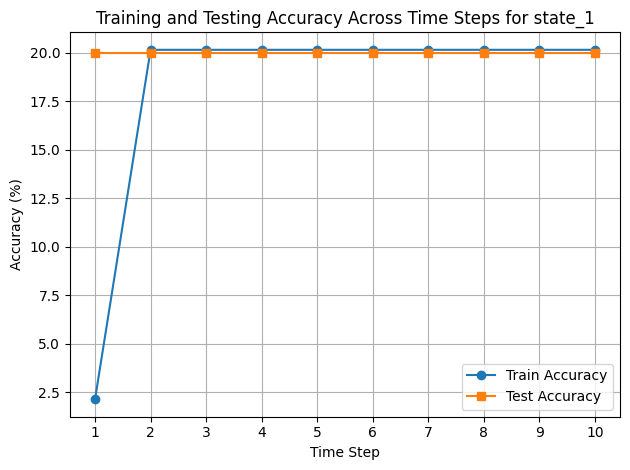

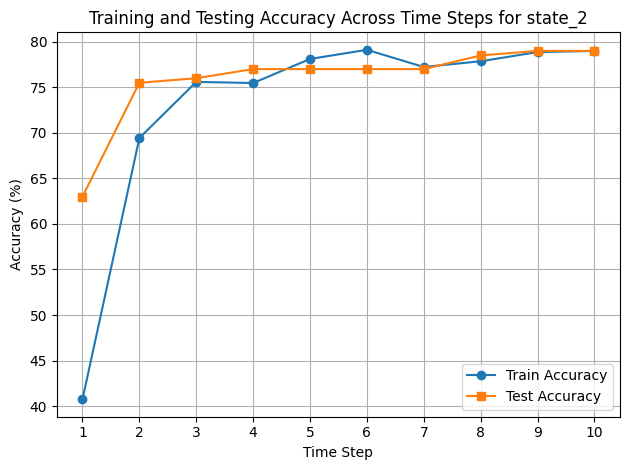

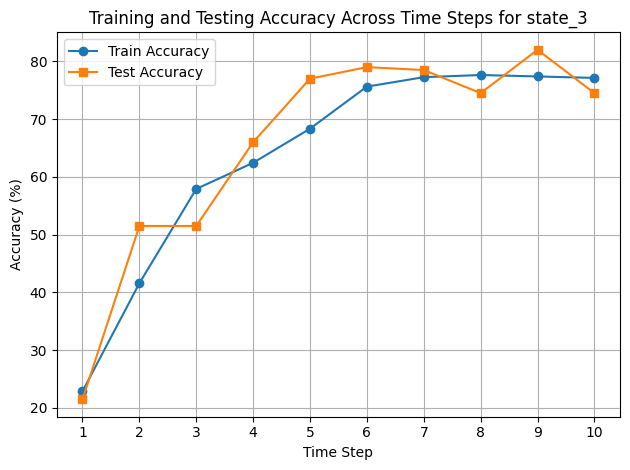

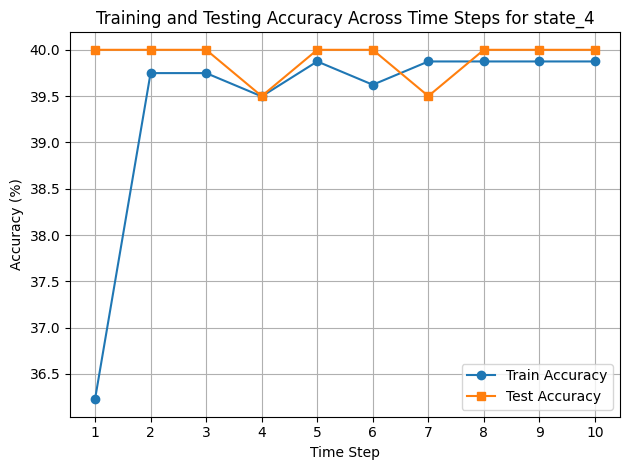

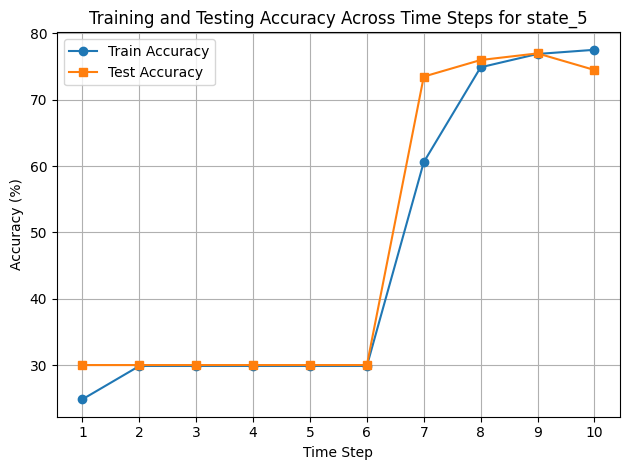

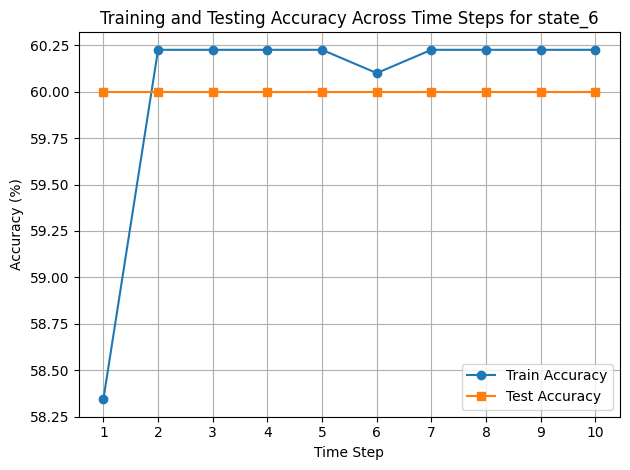

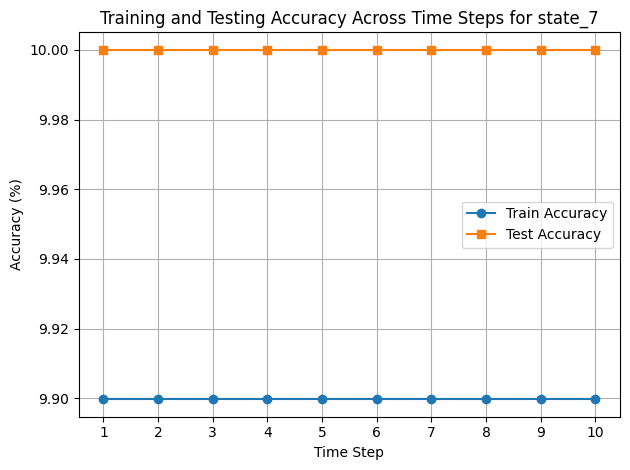

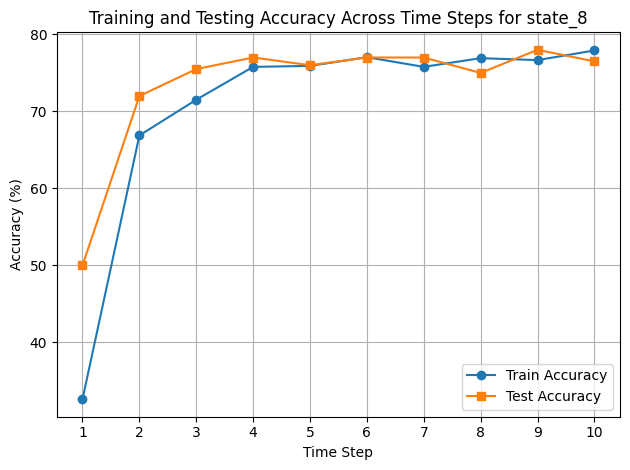

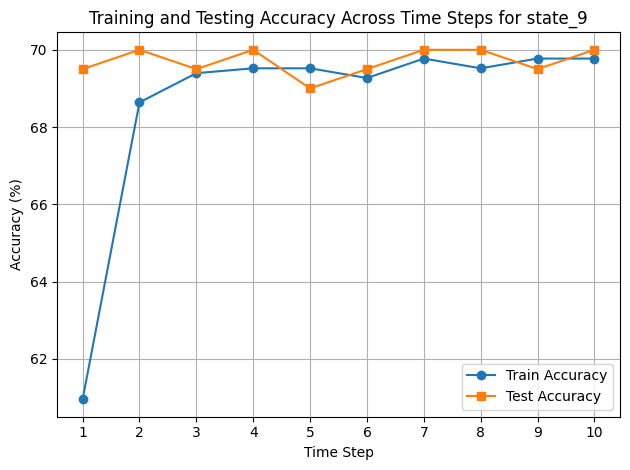

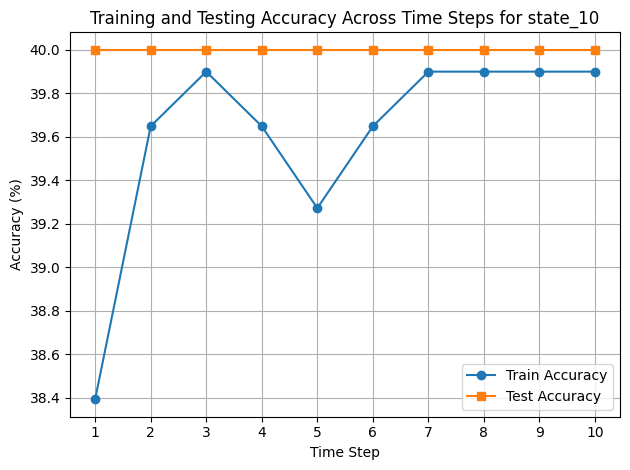

In [ ]:
# Plot results for each state
for state_key, value in results.items():
    plt.figure()
    plt.plot(range(1, T + 1), value['train_accuracies'], label='Train Accuracy', marker='o')
    plt.plot(range(1, T + 1), value['test_accuracies'], label='Test Accuracy', marker='s')
    plt.title(f'Training and Testing Accuracy Across Time Steps for {state_key}')
    plt.xlabel('Time Step')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, T + 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Calculate and plot average accuracy across all states for each time step
average_train_accuracies = np.zeros(T)
average_test_accuracies = np.zeros(T)

for value in results.values():
    average_train_accuracies += np.array(value['train_accuracies'])
    average_test_accuracies += np.array(value['test_accuracies'])

average_train_accuracies /= S
average_test_accuracies /= S

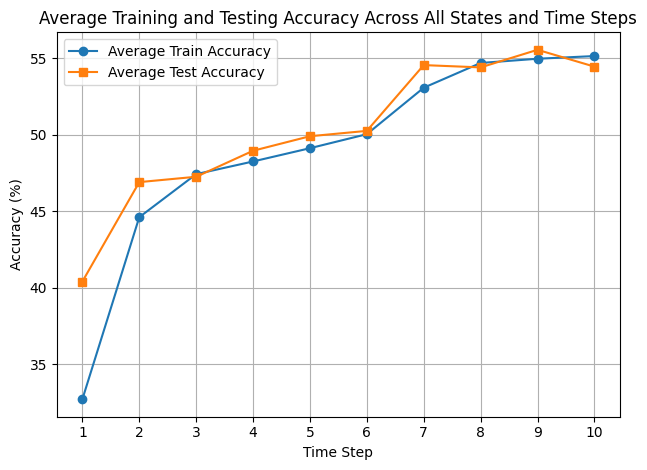

In [ ]:
plt.figure()
plt.plot(range(1, T + 1), average_train_accuracies, label='Average Train Accuracy', marker='o')
plt.plot(range(1, T + 1), average_test_accuracies, label='Average Test Accuracy', marker='s')
plt.title('Average Training and Testing Accuracy Across All States and Time Steps')
plt.xlabel('Time Step')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, T + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/ML_AVG2.png', format='png', dpi=1000)
plt.savefig(f'/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/ML_AVG2.svg', format='svg', dpi=1000)
plt.savefig(f'/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/ML_AVG2.pdf', format='pdf', dpi=1000)
plt.show()

In [ ]:
import csv

# Prepare the header with all time steps
csv_headers = ['State']
for step in range(T):
    csv_headers.append(f'Train Accuracy Step {step + 1}')
    csv_headers.append(f'Test Accuracy Step {step + 1}')

# Convert the results dictionary to a list of dictionaries for CSV export
csv_data = []
for state_key, value in results.items():
    row = {'State': state_key}
    for step in range(T):
        row[f'Train Accuracy Step {step + 1}'] = value['train_accuracies'][step]
        row[f'Test Accuracy Step {step + 1}'] = value['test_accuracies'][step]
    csv_data.append(row)

# Write the CSV file
csv_filename = '/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/ML_results_by_state2.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=csv_headers)
    writer.writeheader()
    writer.writerows(csv_data)

print(f"Results have been exported to {csv_filename}")


Results have been exported to /content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/ML_results_by_state2.csv


# Federated Learning Code

In [ ]:
results = {f"state_{state + 1}": {'train_accuracies': [], 'test_accuracies': []} for state in range(S)}

models = {f"state_{state + 1}": SimpleNN(input_size, output_size).to(device) for state in range(S)}
optimizers = {f"state_{state + 1}": optim.Adam(models[f"state_{state + 1}"].parameters(), lr=0.001) for state in range(S)}
criterion = nn.CrossEntropyLoss()

In [ ]:
for step in range(T):
    for state in range(S):
        train_key = f"train_{step + 1}_{state + 1}"
        test_key = f"test_{step + 1}_{state + 1}"

        if train_key in sklearn_datasets_dict and test_key in sklearn_datasets_dict:
            X_train, y_train = sklearn_datasets_dict[train_key]
            X_test, y_test = sklearn_datasets_dict[test_key]

            train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
            test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            model = models[f"state_{state + 1}"]
            optimizer = optimizers[f"state_{state + 1}"]

            for epoch in range(epochs):
                train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
                test_loss, test_accuracy = test(model, device, test_loader, criterion)

            results[f"state_{state + 1}"]['train_accuracies'].append(train_accuracy)
            results[f"state_{state + 1}"]['test_accuracies'].append(test_accuracy)

    # Federated Learning Step
    if (step + 1) % (T // F) == 0:
        # Compute weights based on test accuracies
        total_accuracy = sum(results[f"state_{state + 1}"]['test_accuracies'][-1] for state in range(S))
        weights = [results[f"state_{state + 1}"]['test_accuracies'][-1] / total_accuracy for state in range(S)]

        # Aggregate models
        global_model = {name: torch.zeros_like(param) for name, param in models['state_1'].named_parameters()}

        for state in range(S):
            for name, param in models[f"state_{state + 1}"].named_parameters():
                global_model[name] += weights[state] * param.data

        # Update local models with the aggregated global model
        for state in range(S):
            for name, param in models[f"state_{state + 1}"].named_parameters():
                param.data = global_model[name]

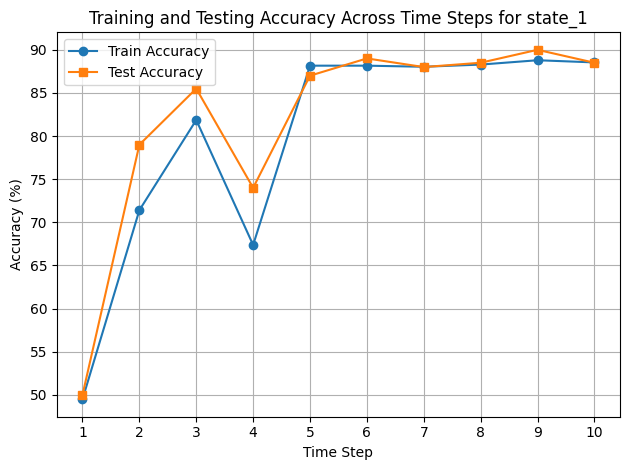

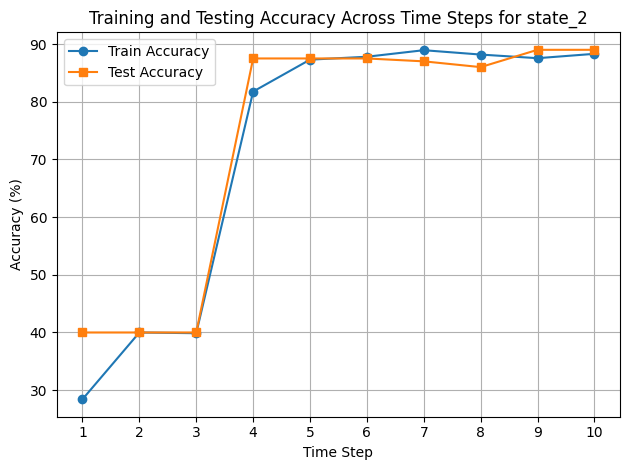

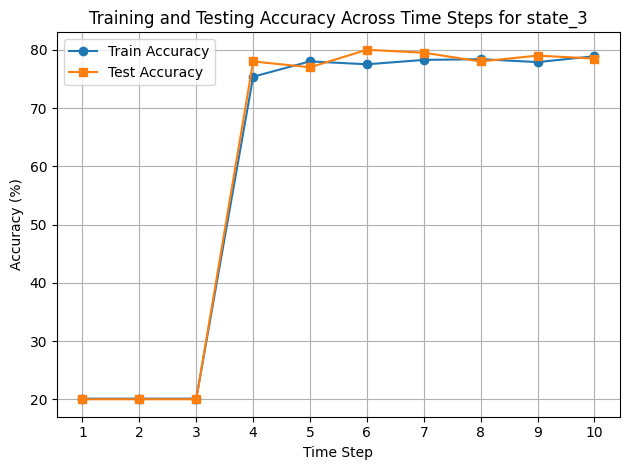

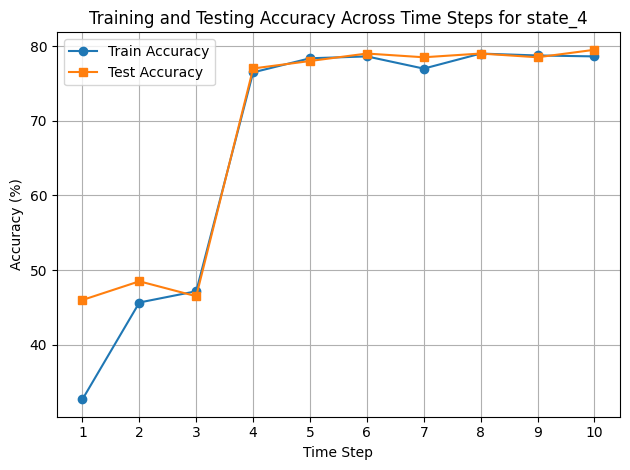

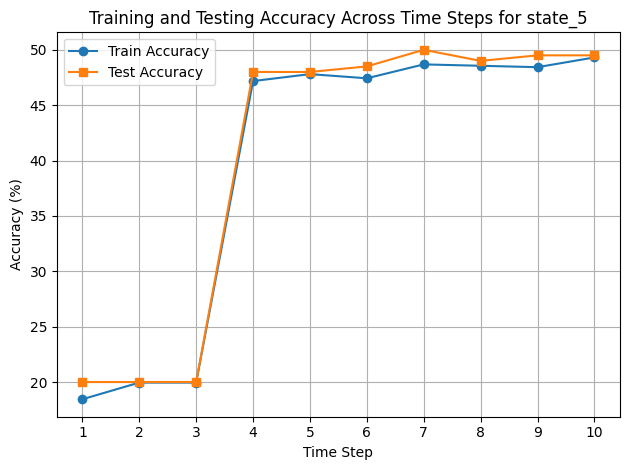

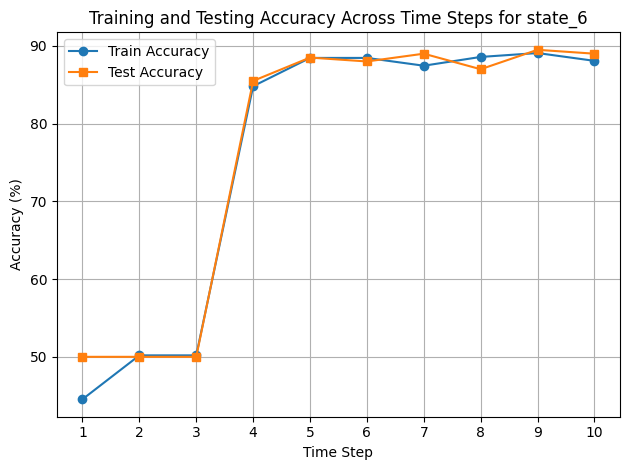

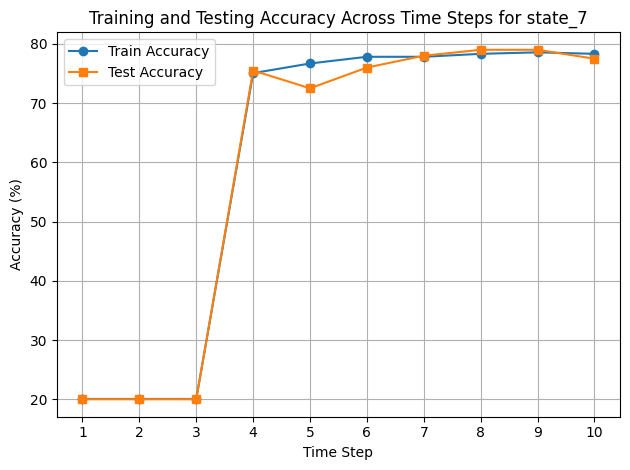

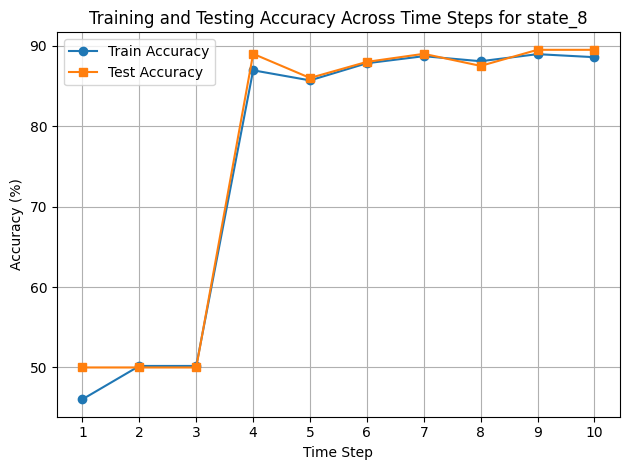

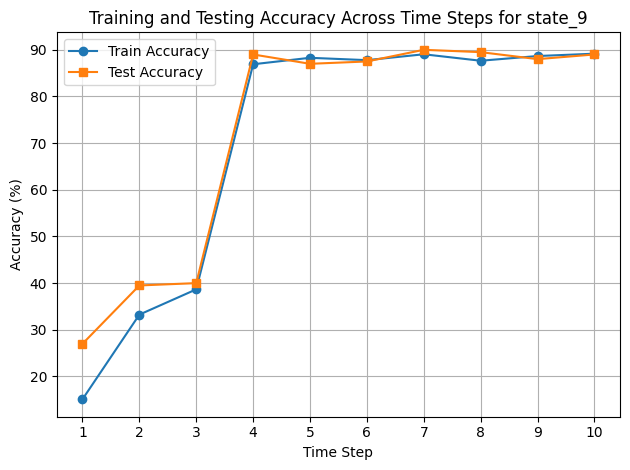

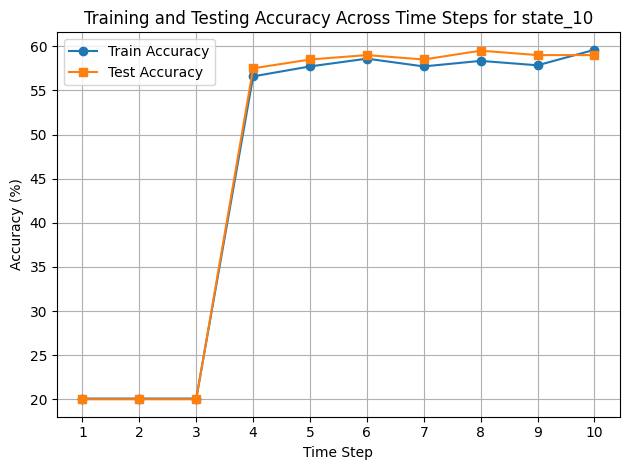

In [ ]:
# Plot results for each state
for state_key, value in results.items():
    plt.figure()
    plt.plot(range(1, T + 1), value['train_accuracies'], label='Train Accuracy', marker='o')
    plt.plot(range(1, T + 1), value['test_accuracies'], label='Test Accuracy', marker='s')
    plt.title(f'Training and Testing Accuracy Across Time Steps for {state_key}')
    plt.xlabel('Time Step')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, T + 1))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Calculate and plot average accuracy across all states for each time step
average_train_accuracies = np.zeros(T)
average_test_accuracies = np.zeros(T)

for value in results.values():
    average_train_accuracies += np.array(value['train_accuracies'])
    average_test_accuracies += np.array(value['test_accuracies'])

average_train_accuracies /= S
average_test_accuracies /= S

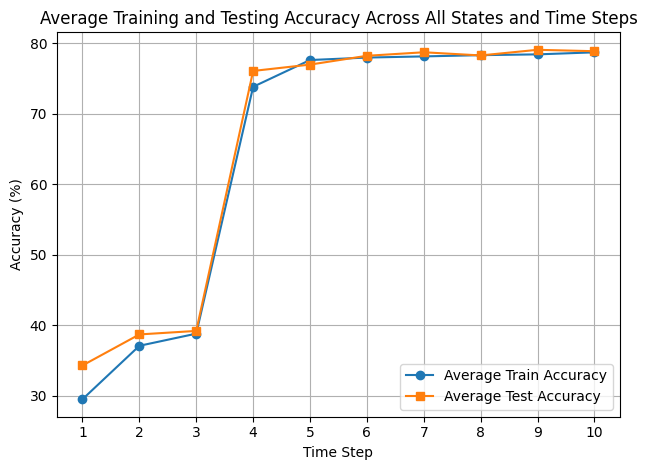

In [ ]:
plt.figure()
plt.plot(range(1, T + 1), average_train_accuracies, label='Average Train Accuracy', marker='o')
plt.plot(range(1, T + 1), average_test_accuracies, label='Average Test Accuracy', marker='s')
plt.title('Average Training and Testing Accuracy Across All States and Time Steps')
plt.xlabel('Time Step')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, T + 1))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/FINAL_FL_AVG.png', format='png', dpi=1000)
plt.savefig(f'/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/FINAL_FL_AVG_FINAL.svg', format='svg', dpi=1000)
plt.savefig(f'/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/FINAL_FL_FINAL.pdf', format='pdf', dpi=1000)
plt.show()

In [ ]:
import csv

# Prepare the header with all time steps
csv_headers = ['State']
for step in range(T):
    csv_headers.append(f'Train Accuracy Step {step + 1}')
    csv_headers.append(f'Test Accuracy Step {step + 1}')

# Convert the results dictionary to a list of dictionaries for CSV export
csv_data = []
for state_key, value in results.items():
    row = {'State': state_key}
    for step in range(T):
        row[f'Train Accuracy Step {step + 1}'] = value['train_accuracies'][step]
        row[f'Test Accuracy Step {step + 1}'] = value['test_accuracies'][step]
    csv_data.append(row)

# Write the CSV file
csv_filename = '/content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/FL_results_by_state.csv'
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=csv_headers)
    writer.writeheader()
    writer.writerows(csv_data)

print(f"Results have been exported to {csv_filename}")


Results have been exported to /content/drive/MyDrive/ICVES 2 Data and Plots/RESULTS PLOTS FINAL/FL_results_by_state.csv
